<a href="https://colab.research.google.com/github/MrPere-Ebibofe/House-Price-/blob/main/HousePrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
          longitude      latitude  housing_median_age   total_rooms  \
coun

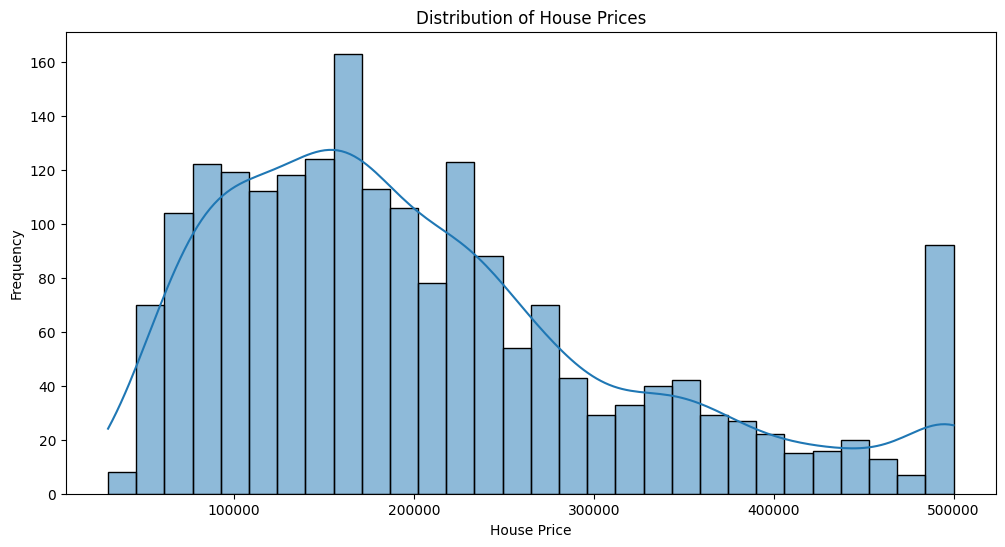

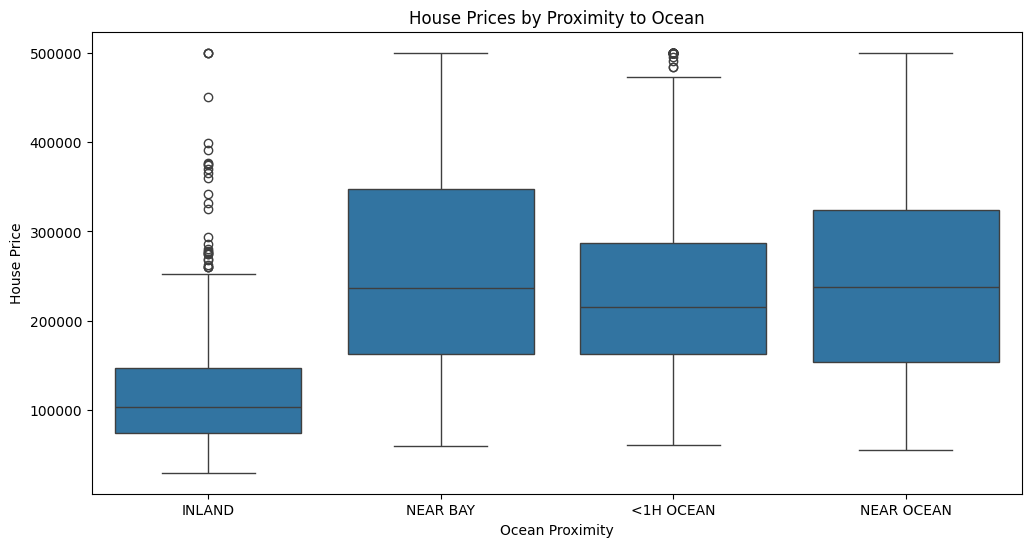

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Test score (Gaussian Process): -1.8396602906587987
Best parameters (Gaussian Process): {'gaussian_pr__alpha': 1e-10, 'gaussian_pr__kernel': 1**2 * RBF(length_scale=1), 'gaussian_pr__n_restarts_optimizer': 0, 'poly__degree': 3}


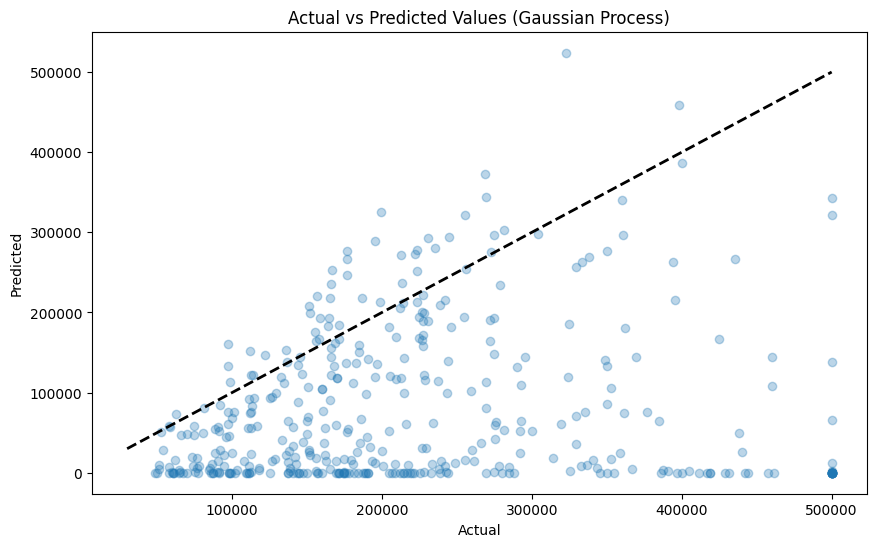

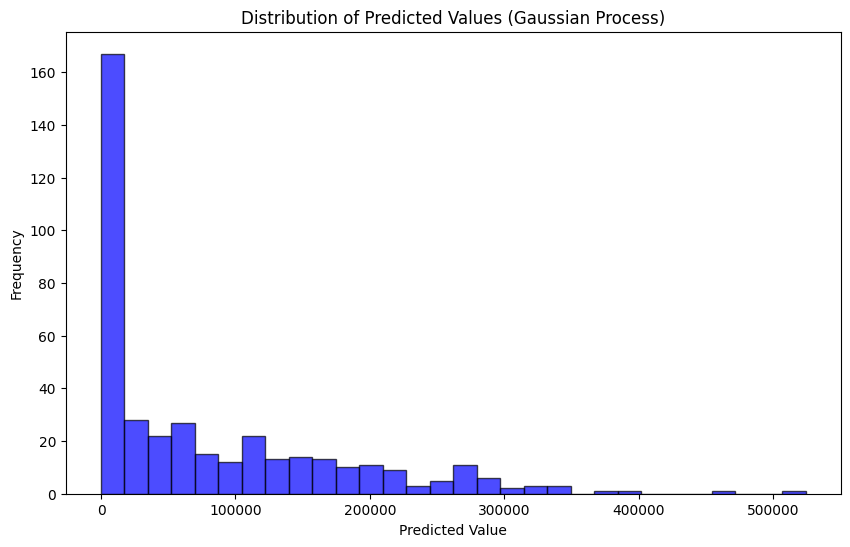

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
file_path = 'housing.csv'
housing_data = pd.read_csv(file_path)

# EDA: Display first few rows of the dataset
print(housing_data.head())

# EDA: Summary statistics
print(housing_data.describe())

# EDA: Missing values
print(housing_data.isnull().sum())

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
housing_data['total_bedrooms'] = imputer.fit_transform(housing_data[['total_bedrooms']])

# Use a smaller sample of the dataset to avoid memory issues
housing_data_sample = housing_data.sample(n=2000, random_state=42)

# Define features and target
X = housing_data_sample.drop(columns=['median_house_value'])
y = housing_data_sample['median_house_value']

# Define categorical and numerical columns
categorical_features = ['ocean_proximity']
numerical_features = X.columns.difference(categorical_features)

# EDA: Visualizations
plt.figure(figsize=(12, 6))
sns.histplot(y, bins=30, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='ocean_proximity', y='median_house_value', data=housing_data_sample)
plt.title('House Prices by Proximity to Ocean')
plt.xlabel('Ocean Proximity')
plt.ylabel('House Price')
plt.show()

# Create column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Add polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Define GaussianProcessRegression class
class GaussianProcessRegression(BaseEstimator, RegressorMixin):
    def __init__(self, kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, normalize_y=False):
        if kernel is None:
            kernel = C(1.0, (1e-3, 1e3)) * (RBF(length_scale=1.0) + RationalQuadratic(length_scale=1.0, alpha=1.0)) + WhiteKernel(noise_level=1)
        self.kernel = kernel
        self.alpha = alpha
        self.optimizer = optimizer
        self.n_restarts_optimizer = n_restarts_optimizer
        self.normalize_y = normalize_y
        self.model = GaussianProcessRegressor(
            kernel=self.kernel,
            alpha=self.alpha,
            optimizer=self.optimizer,
            n_restarts_optimizer=self.n_restarts_optimizer,
            normalize_y=self.normalize_y
        )

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

# Define pipeline with polynomial features
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', poly),
    ('gaussian_pr', GaussianProcessRegression())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'poly__degree': [1, 2, 3],
    'gaussian_pr__alpha': [1e-10, 1e-5, 1e-2],
    'gaussian_pr__n_restarts_optimizer': [0, 5, 10],
    'gaussian_pr__kernel': [
        C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
        C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=1.0),
        C(1.0, (1e-3, 1e3)) * (RBF(length_scale=1.0) + RationalQuadratic(length_scale=1.0, alpha=1.0)) + WhiteKernel(noise_level=1)
    ]
}

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Predict on test set
y_pred = grid_search.predict(X_test)

# Evaluate model
test_score = grid_search.score(X_test, y_test)
print(f"Test score (Gaussian Process): {test_score}")
print(f"Best parameters (Gaussian Process): {grid_search.best_params_}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Gaussian Process)')
plt.show()

# Plot prediction distribution
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=30, alpha=0.7, color='b', edgecolor='k')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Values (Gaussian Process)')
plt.show()


In [2]:

# Alternative Models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print('-' * 30)


# Linear Regression
linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('linear_regression', LinearRegression())
])
evaluate_model(linear_model, X_train, X_test, y_train, y_test)

# Random Forest Regressor
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42))
])
evaluate_model(rf_model, X_train, X_test, y_train, y_test)


Model: Pipeline
Mean Squared Error: 4626158300.99899
R^2 Score: 0.6655138060082795
------------------------------
Model: Pipeline
Mean Squared Error: 3628322994.843596
R^2 Score: 0.737660523018462
------------------------------
